Locate organizations that progressively grew their fundraising volume and identify common attributes, ideally activated features. This will be done primarily by looking at transactions to identify these forms. Then we will examine the organization data snapshots for these forms to see what they changed during this time of increasing fundraising.

In [7]:
import pandas as pd
import numpy as np
import datetime, os

%matplotlib inline

TRANS_PATH = "/Volumes/Untitled/datasets/transactions/transactions.csv"
TRANS_AGG_PATH = "/Users/jeremyvanvalkenburg/Repositories/datasets/transactions/trans_agg_month_sum.csv"
TRANS_PATH = "../transactions/transactions.csv"

# Identify example forms with strong growth

In [2]:
df = pd.read_csv(TRANS_PATH)

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = df[df['status']=='A']
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['year_month'] = df[['year', 'month']].apply(lambda x: str(x['year']) + "/" + str(x['month']), axis=1)

In [4]:
df['recurring_amt'] = df[['amount', 'is_recurring']].apply(lambda x: x['amount'] if x['is_recurring'] else 0., axis=1)

sum_cols = ['amount', 'donations_amt', 'events_amt', 'purchases_amt', 'registrations_amt', 'recurring_amt']
ix_cols = ['org', 'form', 'year_month']

df_agg = df[ix_cols + sum_cols].groupby(ix_cols)[sum_cols].sum().reset_index()

In [5]:
# df_agg.to_csv("/Users/jeremyvanvalkenburg/Repositories/datasets/transactions/trans_agg_month_sum.csv", index=False)
df_agg = pd.read_csv(TRANS_AGG_PATH)
df_agg = df_agg[(df_agg['org']!=0)&(df_agg['form']!=0)]

In [6]:
form_month_counts = df_agg.groupby('form')['year_month'].count().reset_index()
df_agg = df_agg[df_agg['form'].isin(form_month_counts[form_month_counts['year_month']>=6]['form'].tolist())]

In [7]:
df_agg['year_month'] = pd.to_datetime(df_agg['year_month'])
df_agg['donations_amt'] = df_agg['donations_amt'] - df_agg['recurring_amt']

In [8]:
forms = df_agg['form'].unique().tolist()
forms_growth_data = []

for f in forms:
    _df = df_agg[df_agg['form']==f].sort_values('year_month', ascending=True)
    _df['amount_growth_rate'] = _df['amount'].shift(1) / _df['amount']
    _df['donations_growth_rate'] = _df['donations_amt'].shift(1) / _df['donations_amt']
    _df['events_growth_rate'] = _df['events_amt'].shift(1) / _df['events_amt']
    _df['purchases_growth_rate'] = _df['purchases_amt'].shift(1) / _df['purchases_amt']
    _df['registrations_growth_rate'] = _df['registrations_amt'].shift(1) / _df['registrations_amt']
    _df['recurring_growth_rate'] = _df['recurring_amt'].shift(1) / _df['recurring_amt']
    
    forms_growth_data.append({
        'form': f,
        'amount_growth_rate': _df['amount_growth_rate'].mean(),
        'donations_growth_rate': _df['donations_growth_rate'].mean(),
        'events_growth_rate': _df['events_growth_rate'].mean(),
        'purchases_growth_rate': _df['purchases_growth_rate'].mean(),
        'registrations_growth_rate': _df['registrations_growth_rate'].mean(),
        'recurring_growth_rate': _df['recurring_growth_rate'].mean()
    })

In [9]:
growth_df = pd.DataFrame(forms_growth_data).replace([np.inf, -np.inf, np.nan], 0.)
growth_df.head()

,amount_growth_rate,donations_growth_rate,events_growth_rate,form,purchases_growth_rate,recurring_growth_rate,registrations_growth_rate
0,131.818145,0.0,0.0,124,0.0,131.818145,0.0
1,2.939438,0.0,0.0,1,0.0,0.000000,0.0
2,0.000000,0.0,0.0,2,0.0,0.000000,0.0
3,3.241261,0.0,0.0,6171,0.0,0.000000,0.0
4,4.438351,0.0,0.0,3,0.0,0.000000,0.0


In [10]:
growth_df.drop(['form'], axis=1).mean()

amount_growth_rate           115.618065
donations_growth_rate         13.366157
events_growth_rate             0.457953
purchases_growth_rate          0.012507
recurring_growth_rate         48.349474
registrations_growth_rate      0.011083
dtype: float64

In [40]:
len_forms = len(growth_df['form'].unique())
mean_growth = growth_df[growth_df['amount_growth_rate']>0.]['amount_growth_rate'].mean()
len_forms_zero_growth = len(growth_df[growth_df['amount_growth_rate']<=0.])

std_growth = growth_df[growth_df['amount_growth_rate']>0.]['amount_growth_rate'].std()
std_growth_up_boundary = growth_df[growth_df['amount_growth_rate']>0.]['amount_growth_rate'].mean() + std_growth
forms_above_std_boundary = len(growth_df[growth_df['amount_growth_rate']>=std_growth_up_boundary]['form'].unique())

print("{} unique forms with a mean growth rate of {:.2f} and {} forms with a growth rate of 0.0".format(len_forms, mean_growth, len_forms_zero_growth))
print("{} forms 1 std above the mean ({:.4f}%)".format(forms_above_std_boundary, float(forms_above_std_boundary) / float(len(growth_df['form'].unique()))))

top_5_perc = growth_df[growth_df['amount_growth_rate']>0.].sort_values('amount_growth_rate', ascending=False).head(int(len_forms * 0.05))
bottom_5_perc = growth_df[growth_df['amount_growth_rate']>0.].sort_values('amount_growth_rate', ascending=False).tail(int(len_forms * 0.05))

print("{} forms in the top performing 5% with a mean growth rate of {:.4f}".format(len(top_5_perc), top_5_perc['amount_growth_rate'].mean()))
print("{} forms in the bottom performing 5% with a mean growth rate of {:.4f}".format(len(bottom_5_perc), bottom_5_perc['amount_growth_rate'].mean()))

5137 unique forms with a mean growth rate of 122.84 and 302 forms with a growth rate of 0.0
14 forms 1 std above the mean (0.0027%)
256 forms in the top performing 5% with a mean growth rate of 2221.6059
256 forms in the bottom performing 5% with a mean growth rate of 0.9336


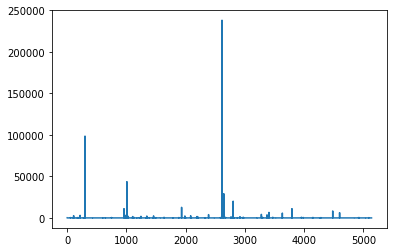

In [26]:
growth_df['amount_growth_rate'].plot(y="amount_growth_rate")

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


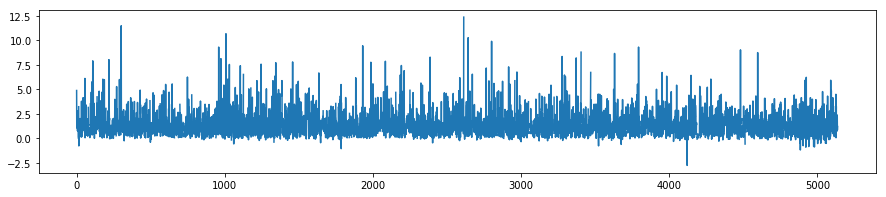

In [47]:
growth_df['amount_growth_rate_log'] = np.log(growth_df['amount_growth_rate'])
growth_df['amount_growth_rate_log'].plot(figsize=(15,3))

In [58]:
len_forms = len(growth_df['form'].unique())
mean_growth = growth_df[growth_df['amount_growth_rate']>0.]['amount_growth_rate'].mean()
len_forms_zero_growth = len(growth_df[growth_df['amount_growth_rate']<=0.])

std_growth = growth_df[growth_df['amount_growth_rate']>0.]['amount_growth_rate_log'].std()
std_growth_up_boundary = growth_df[growth_df['amount_growth_rate']>0.]['amount_growth_rate_log'].mean() + (std_growth * 25.)
forms_above_std_boundary = len(growth_df[growth_df['amount_growth_rate']>=std_growth_up_boundary]['form'].unique())

print("{} unique forms with a mean growth rate of {:.2f} and {} forms with a growth rate of 0.0".format(len_forms, mean_growth, len_forms_zero_growth))
print("{} forms 25 standard deviations above the mean ({:.2f}%)".format(forms_above_std_boundary, (float(forms_above_std_boundary) / float(len(growth_df['form'].unique()))) * 100.))

top_5_perc = growth_df[growth_df['amount_growth_rate']>0.].sort_values('amount_growth_rate', ascending=False).head(int(len_forms * 0.05))
bottom_5_perc = growth_df[growth_df['amount_growth_rate']>0.].sort_values('amount_growth_rate', ascending=False).tail(int(len_forms * 0.05))

print("{} forms in the top performing 5% with a mean growth rate of {:.4f}".format(len(top_5_perc), top_5_perc['amount_growth_rate_log'].mean()))
print("{} forms in the bottom performing 5% with a mean growth rate of {:.4f}".format(len(bottom_5_perc), bottom_5_perc['amount_growth_rate_log'].mean()))

5137 unique forms with a mean growth rate of 122.84 and 302 forms with a growth rate of 0.0
298 forms 25 standard deviations above the mean (5.80%)
256 forms in the top performing 5% with a mean growth rate of 5.1029
256 forms in the bottom performing 5% with a mean growth rate of -0.0948


In [59]:
superior_forms = top_5_perc['form'].tolist()

Here we see there is a superior fundraising set of 298 forms that are greater than 25 standard deviations above the mean of log fundraising growth. We need to examine these superior forms for patterns that separate themselves from the rest of the forms. Once we have isolated these configurations that make these forms different, we should examine their impact on other forms outside of this set to see if we can draw a potentially consequential relationship between these settings and superior growth in fundraising.

In [13]:
msk = (growth_df['donations_growth_rate']!=0)|(growth_df['events_growth_rate']!=0)|(growth_df['purchases_growth_rate']!=0)|(growth_df['recurring_growth_rate']!=0)|(growth_df['registrations_growth_rate']!=0)
cols = ["form", "amount_growth_rate", "donations_growth_rate", "events_growth_rate", "purchases_growth_rate", "recurring_growth_rate", "registrations_growth_rate"]
growth_df[msk].sort_values('amount_growth_rate', ascending=False)[cols].head(5)

,form,amount_growth_rate,donations_growth_rate,events_growth_rate,purchases_growth_rate,recurring_growth_rate,registrations_growth_rate
301,440388,98557.841767,0.000000,0.000000,0.0,98557.841767,0.0
1008,51247,43641.173242,43641.173242,4.704819,0.0,43641.173242,0.0
959,1156,11142.494300,0.000000,0.000000,0.0,11142.494300,0.0
4481,929851,8373.734799,0.000000,0.000000,0.0,8373.734799,0.0
3405,811080,6634.438295,0.000000,0.000000,0.0,6634.438295,0.0


Data points to examine:

1. Recurring enabled
2. Donor logins enabled
3. P2P to Qgiv ratio
4. Form counts
5. Custom receipts (? need to verify how to gather this data)
6. Traffic
7. Social links on donation forms (? need to verify how to gather this data)

## Recurring

It appears that the bulk of sustained growth for all organizations is focused heavily in recurring transactions. Looking at the mean growth rates, it's clear that the forms with the strongest growth can attribute more than half of their processing to recurring. Let's look at the overall transaction volume growth split by one time and recurring.

In [63]:
df['date'] = pd.to_datetime(df['date'])

date_data = []
for d in df['date'].unique():
    onetime = 0.
    recurring = 0.
    
    _this_date = df[df['date']==d]
    if len(_this_date) and len(_this_date[_this_date['is_recurring']==False]):
        onetime = _this_date[_this_date['is_recurring']==False]['amount'].iloc[0]
    if len(_this_date) and len(_this_date[_this_date['is_recurring']==True]):
        recurring = _this_date[_this_date['is_recurring']==True]['amount'].iloc[0]
    date_data.append({
        "date": d,
        "onetime": onetime,
        "recurring": recurring
    })

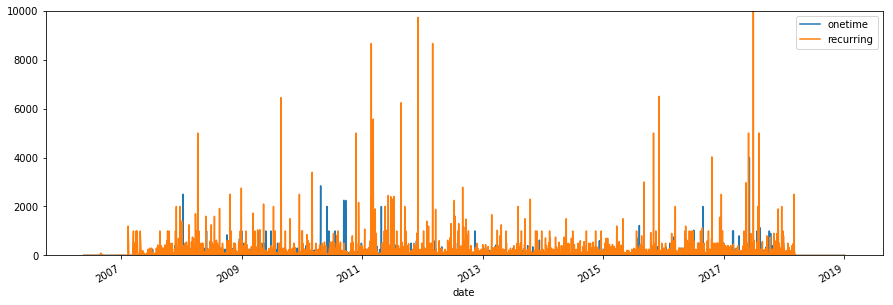

In [111]:
pd.DataFrame(date_data).plot(x="date", y=['onetime', 'recurring'], ylim=(0,10000), figsize=(15,5))

Recurring clearly dominates the processing. Let's look at mean processing volume overall and by year between forms with recurring and without.

In [64]:
# overall processing
form_recurring_counts = df[['form', 'is_recurring']].groupby('form')['is_recurring'].count().reset_index()

w_recurring = form_recurring_counts[form_recurring_counts['is_recurring']>0]
wout_recurring = form_recurring_counts[form_recurring_counts['is_recurring']==0]

print("{} forms with recurring; {} forms without recurring".format(len(w_recurring), len(wout_recurring)))

mean_w_recurring = df[df.form.isin(w_recurring['form'].tolist())]['amount'].sum() / float(len(w_recurring))
mean_wout_recurring = df[df.form.isin(wout_recurring['form'].tolist())]['amount'].sum() / float(len(wout_recurring))

print("${:.2f} mean funds raised w/ recurring; ${:.2f} mean funds raised w/out recurring".format(mean_w_recurring, mean_wout_recurring))

9580 forms with recurring; 4091 forms without recurring
$69486.71 mean funds raised w/ recurring; $7609.34 mean funds raised w/out recurring


Here we see that forms with recurring are raising an order of magnitude greater than those without. This is not groundbreaking as we already knew they did better, but here we have a number. What would be best is to be able to create a story around this. A good story like "recurring transactions will on average generate X% greater volume per donor than those without".

In [302]:
print("Mean one time transaction value: ${:.2f}".format(df[df['is_recurring']==False]['amount'].mean()))
print("Mean recurring transaction value: ${:.2f}".format(df[df['is_recurring']==True]['amount'].mean()))

Mean one time transaction value: $70.86
Mean recurring transaction value: $173.25


In [304]:
173.25/70.86

2.444961896697714

It is oversimplified but I think still fair to say that __donors give 2.4 times the amount in recurring donations than one time.__

In [66]:
# looking at high performing forms recurring rates vs the rest
superior_forms_mean_recurring = form_recurring_counts[form_recurring_counts['form'].isin(superior_forms)]['is_recurring'].mean()
inferior_forms_mean_recurring = form_recurring_counts[~form_recurring_counts['form'].isin(superior_forms)]['is_recurring'].mean()

print("Superior forms mean recurring: {:.2f}".format(superior_forms_mean_recurring))
print("Inferior forms mean recurring: {:.2f}".format(inferior_forms_mean_recurring))

Superior forms mean recurring: 1078.24
Inferior forms mean recurring: 275.63


Here we can see that the __forms with superior growth rates have over 3 times the recurring the transactions__ as the other forms.

## Events

I am looking for events-focused organizations to compare their overall performance to more generalized organizations. Isolating organizations that have exclusively events transactions will (1) exclude those with one time events donations and (2) probably result in a data set too small to be meaningful. I am going to isolate a group with a minimum percentage of volume that still indicates their fundraising is predominantly events.

In [67]:
org_funds_src = df.groupby('org')[['amount','donations_amt','recurring_amt','events_amt','registrations_amt']].sum().reset_index()
for s in ['donations', 'recurring', 'events', 'registrations']:
    org_funds_src[s+'_perc'] = org_funds_src[s+'_amt'] / org_funds_src['amount']

In [68]:
print("{:.2f}% of organizations rely upon events for 50% of funds raised".format(float(len(org_funds_src[org_funds_src['events_perc']>0.5])) / float(len(org_funds_src))))

print("Mean funds raised by orgs with more than 50% events volume: ${:.2f}".format(org_funds_src[org_funds_src['events_perc']>0.5]['amount'].mean()))
print("Mean funds raised by orgs with less than 50% events volume: ${:.2f}".format(org_funds_src[org_funds_src['events_perc']<0.5]['amount'].mean()))
print("Mean funds raised by all orgs: ${:.2f}".format(org_funds_src['amount'].mean()))

0.08% of organizations rely upon events for 50% of funds raised
Mean funds raised by orgs with more than 50% events volume: $116075.82
Mean funds raised by orgs with less than 50% events volume: $173442.06
Mean funds raised by all orgs: $168352.87


Here we see that organizations that rely upon __events for less than 50% of their funds raised will generate about 50% more__ in funds than those that rely upon events for more than 50% of their funds raised. While this is meaningful in terms of volume for the organizations, the number of organizations that rely upon events for more than 50% of their fundraising represents only 8% of all organizations.

__VT USAGE AMONG THOSE PREDOMINANTLY FUNDRAISING THROUGH EVENTS AT BOTTOM OF FOLLOWING SECTION__

In [349]:
predom_events_orgs = org_funds_src[org_funds_src['events_perc']>0.5]['org'].unique().tolist()

### Forms related to event fundraising

In [69]:
form_funds_src = df.groupby('form')[['amount', 'donations_amt','recurring_amt','events_amt','registrations_amt']].sum().reset_index()
for s in ['donations', 'recurring', 'events', 'registrations']:
    form_funds_src[s+'_perc'] = form_funds_src[s+'_amt'] / form_funds_src['amount']

In [73]:
print("All form stats pertaining to event fundraising:")
print("{:.2f}% of forms rely upon events for 50% of funds raised".format(float(len(form_funds_src[form_funds_src['events_perc']>0.5])) / float(len(form_funds_src))))

print("Mean funds raised by forms with more than 50% events volume: ${:.2f}".format(form_funds_src[form_funds_src['events_perc']>0.5]['amount'].mean()))
print("Mean funds raised by forms with less than 50% events volume: ${:.2f}".format(form_funds_src[form_funds_src['events_perc']<0.5]['amount'].mean()))
print("Mean funds raised by all forms: ${:.2f}".format(form_funds_src['amount'].mean()))

print("\nSuperior forms stats:")

print("Superior growth forms event fundraising perc: {:.2f}%".format(form_funds_src[form_funds_src['form'].isin(superior_forms)]['events_perc'].mean() * 100.))
print("Inferior growth forms event fundraising perc: {:.2f}%".format(form_funds_src[~form_funds_src['form'].isin(superior_forms)]['events_perc'].mean() * 100.))

All form stats pertaining to event fundraising:
0.13% of forms rely upon events for 50% of funds raised
Mean funds raised by forms with more than 50% events volume: $31546.99
Mean funds raised by forms with less than 50% events volume: $55584.54
Mean funds raised by all forms: $50970.12

Superior forms stats:
Superior growth forms event fundraising perc: 11.46%
Inferior growth forms event fundraising perc: 13.77%


## Generic source examination

In [334]:
org_src = df.groupby(['org', 'source'])['amount'].sum().reset_index().pivot(index='org', columns='source', values='amount').reset_index().fillna(0.)

sources = ['don_form', 'fb', 'givi', 'kiosk', 'mobile', 'mobilevt', 'p2p', 'sms', 'vt']
org_src['total'] = org_src[sources].sum(axis=1)
for s in sources:
    org_src[s+'_perc'] = org_src[s] / org_src['total']

In [374]:
org_totals = df.groupby('org')['amount'].sum().reset_index()
org_src['total'] = org_src['org'].apply(lambda x: org_totals[org_totals['org']==x]['amount'].iloc[0])

print("Top 50 fundraising orgs source distribution:")
perc_cols = ['don_form_perc', 'fb_perc', 'givi_perc', 'kiosk_perc', 'mobile_perc', 'mobilevt_perc', 'p2p_perc', 'sms_perc', 'vt_perc']
org_src.sort_values('total', ascending=False).head(50)[perc_cols].mean()

Top 50 fundraising orgs source distribution:


source
don_form_perc    0.669750
fb_perc          0.000158
givi_perc        0.000121
kiosk_perc       0.057447
mobile_perc      0.076804
mobilevt_perc    0.005106
p2p_perc         0.043411
sms_perc         0.002691
vt_perc          0.144512
dtype: float64

In [340]:
p2p_orgs = org_src[org_src['p2p']>0.]

only_p2p = p2p_orgs[p2p_orgs['p2p_perc']==1.]
notonly_p2p = p2p_orgs[p2p_orgs['p2p_perc']!=1.]

print("P2P orgs:")
print("Mean funds raised w/out year round: ${:.2f} ({} orgs)".format(only_p2p['total'].mean(), len(only_p2p)))
print("Mean funds raised w/ year round: ${:.2f} ({} orgs)".format(notonly_p2p['total'].mean(), len(notonly_p2p)))

P2P orgs:
Mean funds raised w/out year round: $11558.63 (11 orgs)
Mean funds raised w/ year round: $297253.93 (502 orgs)


Organizations with P2P forms raise __more than 25 times more__ when they also use year round forms than those only using P2P. The group of exclusively P2P organizations represents 2% of the P2P organizations.

In [345]:
sms_orgs = org_src[org_src['sms']>0.]

only_sms = sms_orgs[sms_orgs['sms_perc']>.5]
notonly_sms = sms_orgs[sms_orgs['sms_perc']<.5]

print("SMS orgs:")
print("Mean funds raised for orgs predominatly using SMS: ${:.2f} ({} orgs)".format(only_sms['total'].mean(), len(only_sms)))
print("Mean funds raised for orgs not predominantly using SMS: ${:.2f} ({} orgs)".format(notonly_sms['total'].mean(), len(notonly_sms)))

SMS orgs:
Mean funds raised for orgs predominatly using SMS: $2843.25 (235 orgs)
Mean funds raised for orgs not predominantly using SMS: $490134.05 (590 orgs)


Of organizations utilizing SMS, those which do not rely upon SMS for the majority of their fundraising raise __more than 172 times more__ than those that do rely upon SMS for the majority of their fundraising.

In [364]:
# looking at VT usage among predominantly event-based organizations
org_src['all_vt_perc'] = org_src['vt_perc'] + org_src['mobilevt_perc']
predom_events_src = org_src[org_src.org.isin(predom_events_orgs)]

print("Amount buckets for predominantly events based organizations based upon VT use:")
print("Mean total: {:.2f} ({} orgs)".format(predom_events_src['total'].mean(), len(predom_events_src)))
for t in [0.01, 0.02, 0.1, 0.2]:
    print("Threshold: {}; mean total: {:.2f} ({} orgs)".format(t, predom_events_src[predom_events_src['all_vt_perc']>t]['total'].mean(), len(predom_events_src[predom_events_src['all_vt_perc']>t])))

Amount buckets for predominantly events based organizations based upon VT use:
Mean total: 116075.82 (343 orgs)
Threshold: 0.01; mean total: 168403.48 (128 orgs)
Threshold: 0.02; mean total: 173491.96 (110 orgs)
Threshold: 0.1; mean total: 151441.86 (67 orgs)
Threshold: 0.2; mean total: 147681.79 (33 orgs)


There is certainly a positive correlation between VT usage and total funds raised, but I'm not yet sure how to extract a good story or bullet point from these stats. __Perhaps it is fair to say that organizations are raising 1.4 times when they use the VT at their events.__

## Superior fundraising forms

In [88]:
form_src = df.groupby(['form', 'source'])['amount'].sum().reset_index().pivot(index='form', columns='source', values='amount').reset_index().fillna(0.)

sources = ['don_form', 'fb', 'givi', 'kiosk', 'mobile', 'mobilevt', 'p2p', 'sms', 'vt']
form_src['total'] = form_src[sources].sum(axis=1)
for s in sources:
    form_src[s+'_perc'] = form_src[s] / form_src['total']

In [99]:
sup_form_srcs = form_src[form_src['form'].isin(superior_forms)].drop('form', axis=1).mean()
inf_form_srcs = form_src[~form_src['form'].isin(superior_forms)].drop('form', axis=1).mean()

pd.DataFrame([sup_form_srcs, inf_form_srcs])[['don_form_perc','fb_perc','givi_perc','kiosk_perc','mobile_perc','mobilevt_perc','p2p_perc','sms_perc','vt_perc']]

source,don_form_perc,fb_perc,givi_perc,kiosk_perc,mobile_perc,mobilevt_perc,p2p_perc,sms_perc,vt_perc
0,0.627917,0.000819,0.000000,0.023178,0.036401,0.021068,0.201099,0.026245,0.063274
1,0.623619,0.001609,0.006423,0.013790,0.052744,0.016261,0.179127,0.033354,0.073070


# Retention between one time and recurring

In [113]:
# identify donors grouped by org
df_donor_agg = df.groupby(['org', 'email']).agg({'amount': 'sum', 'date': 'count'}).reset_index()
df_donor_agg['count'] = df_donor_agg['date']
df_donor_agg['sum'] = df_donor_agg['amount']
df_donor_agg.drop(['date', 'amount'], axis=1, inplace=True)

In [114]:
print("{} donors grouped by org; {:.2f} donors per org".format(len(df_donor_agg), float(len(df_donor_agg)) / float(len(df_donor_agg['org'].unique()))))
df_donor_agg.head()

1866108 donors grouped by org; 450.86 donors per org


,org,email,count,sum
0,0,da39a3ee5e6b4b0d3255bfef95601890afd80709,7,265.0
1,6,00755f8827dd4a4a9def5a61755755697e754d73,1,40.0
2,6,008f2558b31746e52aac2a521f41f02bfa619b56,2,510.0
3,6,03f2987650f89468569c3cb71f702f942fb9b1c1,4,915.0
4,6,0430449029d7ed0dd1716f66f6adfebf1a86b55e,1,26.0


In [115]:
df_org_retention = df_donor_agg.groupby('org')[['count', 'sum']].mean().reset_index()
df_org_retention.head()

,org,count,sum
0,0,7.000000,265.000000
1,6,7.096681,888.889004
2,9,13.909091,12.229545
3,13,1.891545,299.419697
4,17,1.367347,538.979592


In [117]:
df['is_recurring'] = df['is_recurring'].astype('bool')
org_recurring = df.groupby(['org'])['is_recurring'].mean().reset_index()

orgs_with_low_recurring = org_recurring[org_recurring['is_recurring']<=0.25]['org'].tolist()
orgs_with_low_recurring_donors = df_donor_agg[df_donor_agg['org'].isin(orgs_with_low_recurring)][['count', 'sum']].mean()

print("Low recurring:")
print("\tCount: {:.2f}; sum: {:.2f}".format(orgs_with_low_recurring_donors['count'].mean(), orgs_with_low_recurring_donors['sum'].mean()))

orgs_with_recurring_donors = df_donor_agg[~df_donor_agg['org'].isin(orgs_with_low_recurring)][['count', 'sum']].mean()

print("Nonlow recurring:")
print("\tCount: {:.2f}; sum: {:.2f}".format(orgs_with_recurring_donors['count'].mean(), orgs_with_recurring_donors['sum'].mean()))

Low recurring:
	Count: 14.10; sum: 970.32
Nonlow recurring:
	Count: 2.63; sum: 369.00


looks like recurring ratios are not going to lead anywhere productive but I'm sure there's something to be found in retention as calculated by average donations per donor, so going to continue digging into that

In [403]:
org_mean_donations_per_donor = df_donor_agg.groupby('org')['count'].mean().reset_index()

In [412]:
mean_donations_per_donor = org_mean_donations_per_donor['count'].mean()

print("{} orgs in sample with {:.2f} mean donations per donor".format(len(org_mean_donations_per_donor), mean_donations_per_donor))

orgs_gt_mean = len(org_mean_donations_per_donor[org_mean_donations_per_donor['count']>mean_donations_per_donor])
orgs_gt_five = len(org_mean_donations_per_donor[org_mean_donations_per_donor['count']>5.])
orgs_gt_ten = len(org_mean_donations_per_donor[org_mean_donations_per_donor['count']>10.])
orgs_gt_twenty = len(org_mean_donations_per_donor[org_mean_donations_per_donor['count']>20.])

print("{} orgs greater than the mean; {} orgs with 5+; {} orgs with 10+; {} orgs with 20+".format(orgs_gt_mean, orgs_gt_five, orgs_gt_ten, orgs_gt_twenty))

4139 orgs in sample with 2.80 mean donations per donor
850 orgs greater than the mean; 456 orgs with 5+; 203 orgs with 10+; 36 orgs with 20+


Here we see a little more than 10% have twice the mean retention, 5% have 4 times the mean retention, and less than 1% have 8 times the mean retention. Need to iterate through these groups examining the organization characteristics:

- recurring rate
- source distributions
- age of organization
- everything?

In [433]:
masks = [mean_donations_per_donor, 5., 10., 20.]
src_perc_cols = ['don_form_perc', 'fb_perc', 'givi_perc', 'kiosk_perc', 'mobile_perc', 'mobilevt_perc',
               'p2p_perc', 'sms_perc', 'vt_perc', 'all_vt_perc']

print("No mask, full data set:")
print("\torganizations: {}".format(len(org_mean_donations_per_donor['org'].unique())))
print("\tmean donations per donor: {:.2f}".format(org_mean_donations_per_donor['count'].mean()))

print("\tmean recurring: {:.4f}".format(org_recurring['is_recurring'].mean()))
print("\tsource distribution:")
for _c in src_perc_cols:
    print("\t\t{}: {:.4f}".format(_c, org_src[_c].mean()))
print("-"*40)

for msk in masks:
    full_msk = org_mean_donations_per_donor['count']>msk
    these_orgs = org_mean_donations_per_donor[full_msk]
    
    mean_per_donor_donations = these_orgs['count'].mean()
    
    # get recurring rate
    rec_dists = org_recurring[org_recurring['org'].isin(these_orgs['org'].tolist())]
    
    # get source distributions
    src_dists = org_src[org_src['org'].isin(these_orgs['org'].tolist())]
    
    # donor login activation rate?
    # frontend edits?
    
    # mean org age
    mean_start_date = df[df['org'].isin(these_orgs['org'].tolist())].groupby('org')['date'].first().reset_index()
    mean_start_date['date_diff'] = datetime.datetime.today() - mean_start_date['date']
    
    print("Mask: > {} donations per donor:".format(msk))
    print("\torganizations: {}".format(len(these_orgs['org'].unique())))
    print("\tmean age: {}".format(mean_start_date['date_diff'].mean()))
    print("\tmean donations per donor: {:.2f}".format(mean_per_donor_donations))
    
    print("\tmean recurring: {:.4f}".format(rec_dists['is_recurring'].mean()))
    
    print("\tsource distribution:")
    for _c in src_perc_cols:
        print("\t\t{}: {:.4f}".format(_c, src_dists[_c].mean()))
    print("-"*40)

No mask, full data set:
	organizations: 4139
	mean donations per donor: 2.80
	mean recurring: 0.8748
	source distribution:
		don_form_perc: 0.6947
		fb_perc: 0.0020
		givi_perc: 0.0012
		kiosk_perc: 0.0291
		mobile_perc: 0.0406
		mobilevt_perc: 0.0113
		p2p_perc: 0.0764
		sms_perc: 0.0598
		vt_perc: 0.0850
		all_vt_perc: 0.0962
----------------------------------------
Mask: > 2.7980628668 donations per donor:
	organizations: 850
	mean age: 2138 days 09:15:10.110784
	mean donations per donor: 8.02
	mean recurring: 0.6264
	source distribution:
		don_form_perc: 0.6992
		fb_perc: 0.0019
		givi_perc: 0.0022
		kiosk_perc: 0.0889
		mobile_perc: 0.0571
		mobilevt_perc: 0.0118
		p2p_perc: 0.0018
		sms_perc: 0.0365
		vt_perc: 0.1006
		all_vt_perc: 0.1124
----------------------------------------
Mask: > 5.0 donations per donor:
	organizations: 456
	mean age: 2200 days 00:50:22.310647
	mean donations per donor: 11.77
	mean recurring: 0.5974
	source distribution:
		don_form_perc: 0.6453
		fb_perc: 

_Note to self... it looks like retention rates are lower among P2P donors, which makes sense. Assuming a prototypical donor for P2P and a year round form, the functional relationship that leads to a transaction for P2P is between the donor and the registrant whereas the functional relationship that leads to a transaction for year round is between the donor and the organization. This warrants further investigation._

## Superior fundraising forms

In [100]:
# identify donors grouped by org
df_donor_agg = df.groupby(['form', 'email']).agg({'amount': 'sum', 'date': 'count'}).reset_index()
df_donor_agg['count'] = df_donor_agg['date']
df_donor_agg['sum'] = df_donor_agg['amount']
df_donor_agg.drop(['date', 'amount'], axis=1, inplace=True)

In [101]:
df_form_retention = df_donor_agg.groupby('form')[['count', 'sum']].mean().reset_index()
df_form_retention.head()

,form,count,sum
0,0,7.000000,265.000000
1,1,6.930535,887.403878
2,2,16.742857,14.317143
3,3,2.055679,459.862973
4,4,1.367347,538.979592


In [104]:
df_form_retention['superior_form'] = df_form_retention['form'].isin(superior_forms)
df_form_retention.groupby('superior_form')[['count', 'sum']].mean().reset_index()

,superior_form,count,sum
0,False,2.194834,367.727043
1,True,2.594635,621.921342


Examining the retention and average funds per donor split by superior growth forms vs the other forms, we see that the forms with __superior growth rate don't have significantly higher retention__. Rather these forms seem to be raising __significantly more per donation, or per donor__. 

This is obviously not an actionable data point but worth noting as this tells us how these forms are growing. Given the ratios of the growth rates and amounts raised, it is clear that the forms with the greatest growth rates are somehow illiciting bigger donations from their donors. The growth does not appear to be seated in greater traffic or retaining donors.

# Donor logins

In [106]:
ANALYTICS_PATH = "/Volumes/Untitled/datasets/analytics/a_base.csv"
ANALYTICS_QGIV_PATH = "/Volumes/Untitled/datasets/analytics/analytic_qgiv_stats.csv"

In [107]:
df_analytics_qgiv = pd.read_csv(ANALYTICS_QGIV_PATH, engine='python', encoding='utf-8', error_bad_lines=False)

Skipping line 14519449: unexpected end of data


In [108]:
org_dl_count = df_analytics_qgiv.groupby('org')['dl_trans_count'].sum().reset_index()

In [118]:
def get_mean_donations(org):
    if len(df_org_retention[df_org_retention['org']==org]['count']):
        return df_org_retention[df_org_retention['org']==org]['count'].iloc[0]
    else:
        return np.NaN
    
def get_recurring_count(org):
    if len(org_recurring[org_recurring['org']==org]['is_recurring']):
        return org_recurring[org_recurring['org']==org]['is_recurring'].iloc[0]
    else:
        return np.NaN

org_dl_count['mean_donations_per_donor'] = org_dl_count['org'].apply(get_mean_donations)
org_dl_count['recurring_rate'] = org_dl_count['org'].apply(get_recurring_count)
org_dl_count.head()

,org,dl_trans_count,mean_donations_per_donor,recurring_rate
0,6,188,7.096681,0.985360
1,9,0,13.909091,0.490196
2,13,4,1.891545,0.934340
3,31,0,1.714032,0.833161
4,33,5,9.688581,0.232321


In [119]:
len_org_w_dl = len(org_dl_count[org_dl_count['dl_trans_count']>0])

print("Orgs with DL transactions: {} out of {}".format(len_org_w_dl, len(org_dl_count)))

print("Org dl trans count buckets:")
print("\t0-50: {}".format(len(org_dl_count[(org_dl_count['dl_trans_count']>0)&(org_dl_count['dl_trans_count']<50)])))
print("\t50-100: {}".format(len(org_dl_count[(org_dl_count['dl_trans_count']>50)&(org_dl_count['dl_trans_count']<100)])))
print("\t100-1000: {}".format(len(org_dl_count[(org_dl_count['dl_trans_count']>100)&(org_dl_count['dl_trans_count']<1000)])))
print("\t1000+: {}".format(len(org_dl_count[org_dl_count['dl_trans_count']>1000])))

print("Mean donations per donor:")
print("\t0 dl trans: {:.2f}".format(org_dl_count[org_dl_count['dl_trans_count']==0]['mean_donations_per_donor'].mean()))
print("\t< 20 dl trans: {:.2f}".format(org_dl_count[(org_dl_count['dl_trans_count']>0)&(org_dl_count['dl_trans_count']<20)]['mean_donations_per_donor'].mean()))
print("\t20 - 50 dl trans: {:.2f}".format(org_dl_count[(org_dl_count['dl_trans_count']>20)&(org_dl_count['dl_trans_count']<50)]['mean_donations_per_donor'].mean()))
print("\t50+: {:.2f}".format(org_dl_count[org_dl_count['dl_trans_count']>50]['mean_donations_per_donor'].mean()))

print("Mean recurring rate:")
print("\t0 dl trans: {:.2f}".format(org_dl_count[org_dl_count['dl_trans_count']==0]['recurring_rate'].mean()))
print("\t< 20 dl trans: {:.2f}".format(org_dl_count[(org_dl_count['dl_trans_count']>0)&(org_dl_count['dl_trans_count']<20)]['recurring_rate'].mean()))
print("\t20 - 50 dl trans: {:.2f}".format(org_dl_count[(org_dl_count['dl_trans_count']>20)&(org_dl_count['dl_trans_count']<50)]['recurring_rate'].mean()))
print("\t50+: {:.2f}".format(org_dl_count[org_dl_count['dl_trans_count']>50]['recurring_rate'].mean()))

Orgs with DL transactions: 1006 out of 2943
Org dl trans count buckets:
	0-50: 812
	50-100: 51
	100-1000: 119
	1000+: 23
Mean donations per donor:
	0 dl trans: 2.39
	< 20 dl trans: 2.74
	20 - 50 dl trans: 4.61
	50+: 9.34
Mean recurring rate:
	0 dl trans: 0.90
	< 20 dl trans: 0.85
	20 - 50 dl trans: 0.75
	50+: 0.75


It looks like user adoption of donor login has definite impact on donor retention. We see a rise in donations per donor with the number of donor login transactions. This relation does not appear to be as clean between donor login associated transactions and recurring rate. This is not an absolute metric so it cannot be said that there is a negative relationship between donor login transactions and recurring transactions, but rather that the recurring rate is negatively associated with donor login transactions.

I am not sure how to characterize this... perhaps __donor logins can lead to up to 4 times the donations (by count, not volume) per donor__?

## Superior growth forms examination

In [126]:
superior_orgs = df[df['form'].isin(superior_forms)]['org'].unique().tolist()
org_dl_count['superior_growth'] = org_dl_count['org'].isin(superior_orgs)
org_dl_count.groupby('superior_growth')[['dl_trans_count', 'mean_donations_per_donor', 'recurring_rate']].mean().reset_index()

,superior_growth,dl_trans_count,mean_donations_per_donor,recurring_rate
0,False,28.786802,3.019798,0.870969
1,True,67.870270,2.999938,0.878012


Here we see somewhat surprising results where the organizations with the superior growth do not exhibit greater donor login donations per donor or recurring rate. Both are sufficiently close to consider them equal. The transaction count on the other hand is unsurprisingly greater, but the fact that it is more than double the transaction count of the organizations with inferior growth is significant. __Having double the average donor login transactions is indicative of greater adoption of donor logins amongst this subset, but we cannot assume that these donors will always give more.__

# Scratch - clean & export integrations and org data

In [113]:
INT_PATH = "/Users/jeremyvanvalkenburg/Repositories/datasets/integrations_org_download.csv"
ORG_PATH = "/Users/jeremyvanvalkenburg/Repositories/datasets/churn/organizations.csv"

In [139]:
df_int = pd.read_csv(INT_PATH)
df_org = pd.read_csv(ORG_PATH)

In [140]:
# replacing original columns
df_int.drop("In Progress?", axis=1, inplace=True)
for c in df_int.columns:
    new_col = c.lower().replace(' ', '_')
    if new_col == 'org':
        new_col = "org_name"
    df_int[new_col] = df_int[c]
    df_int.drop(c, axis=1, inplace=True)
    
df_int.head()

,org_name,service,status,frequency,last_export_date,last_export_result
0,The Gateway Center for World Mission,MailChimp,Active,Manual,2016-08-17 10:24:28,Failed
1,The Gateway Center for World Mission,Bloomerang,Active,Manual,2016-11-15 12:01:44,Success
2,Wolf River Conservancy,DonorPerfect,Active,Manual,2019-04-24 08:42:30,Success
3,2 Hands 2 Cans,MailChimp,Active,Manual,2016-06-28 12:04:22,Some Failures
4,A Piece of My Heart Foundation,Constant Contact,Active,Continuous,2019-05-05 16:20:48,Success


In [165]:
def map_names_to_id(name):
    if len(df_org[df_org['org_name']==name]['id']):
        return df_org[df_org['org_name']==name]['id'].iloc[0]
    else:
        return np.NaN

df_int['org'] = df_int['org_name'].apply(map_names_to_id)
df_int['last_export_date'] = df_int['last_export_date'].apply(lambda x: np.NaN if x == 'Never' or x == 'Unknown' else x)
df_int['last_export_result'] = df_int['last_export_result'].fillna('')

In [173]:
int_cols = ["org", "service", "status", "frequency", "last_export_date", "last_export_result"]
df_int['org'] = df_int['org'].fillna(0).astype(int)
df_int['last_export_date'] = pd.to_datetime(df_int['last_export_date'])

df_int[int_cols].head()

,org,service,status,frequency,last_export_date,last_export_result
0,428077,MailChimp,Active,Manual,2016-08-17 10:24:28,Failed
1,428077,Bloomerang,Active,Manual,2016-11-15 12:01:44,Success
2,441727,DonorPerfect,Active,Manual,2019-04-24 08:42:30,Success
3,430180,MailChimp,Active,Manual,2016-06-28 12:04:22,Some Failures
4,442516,Constant Contact,Active,Continuous,2019-05-05 16:20:48,Success


In [181]:
#df_int[int_cols].to_csv(INT_PATH.replace('.csv', '.clean.csv'), index=False)
df_int['last_export_date'] = pd.to_datetime(df_int['last_export_date'])
df_int[df_int['org']==27648][int_cols].fillna(np.NaN).head(50)

,org,service,status,frequency,last_export_date,last_export_result
199,27648,Constant Contact,Active,Manual,NaT,
200,27648,Qgiv for Salesforce,Active,Continuous,2019-05-04,Import Successful


In [137]:
for c in df_org.columns:
    df_org[c.lower().replace(' ', '_').replace('go_', '')] = df_org[c]
    df_org.drop(c, axis=1, inplace=True)

drop_cols = ['sic', 'street']
df_org.drop(drop_cols, axis=1, inplace=True)

df_org.head()

,id,org_name,tax_id,city,state,zip,country,live_date,signup_step_one,first_transaction_date,...,status,pricing_package,reseller,previously_accepted_credit_online,segment,tags,date_closed,reason_closed,new_provider,additional_churn_info
0,441789,NaN,821776812,Katy,TX,77494,US,12/31/1969,08/16/2017,NaN,...,pending,Start,Qgiv,No,Z - Unknown,NaN,NaN,NaN,NaN,NaN
1,443044,NaN,155627786,NaN,South Carolina,NaN,US,12/31/1969,07/24/2018,NaN,...,pending,Start,Qgiv,No,NaN,NaN,NaN,NaN,NaN,NaN
2,1045,FROM Food Fight,NaN,Lowell,MI,49331,US,03/14/2011,NaN,05/03/2011,...,closed,Legacy Pricing,Z- Mission Research,No,NaN,NaN,2011-06-30 00:00:00,Voluntary - Automatically Updated,NaN,NaN
3,442134,Camp Laurelwood,060693092,madison,CT,06443,US,11/06/2017,11/06/2017,11/09/2017,...,active,Start,Qgiv,Yes,"N - Recreation, Sports, Leisure, Athletics",SFDC - Organic Search,NaN,NaN,NaN,NaN
4,442293,Cass Community Social Services,383429921,Detroit,MI,48206,US,01/29/2018,01/29/2018,02/19/2018,...,active,Start,Qgiv,No,P - Human Services,SFDC - Organic Search,NaN,NaN,NaN,NaN


In [271]:
df_org['org_name'] = df_org['org_name'].fillna('').apply(lambda x: x.replace(',', ''))
df_org['tax_id'] = df_org['tax_id'].apply(lambda x: '' if (x == 'NaN' or x == 0) else x)
df_org['city'] = df_org['city'].fillna('')
df_org['state'] = df_org['state'].fillna('')
df_org['zip'] = df_org['zip'].fillna('').apply(lambda x: '' if x == 'NaN' else x)
df_org['country'] = df_org['country'].fillna('')
df_org['live_date'] = df_org['live_date'].apply(lambda x: '' if x == 'NaN' else x)
df_org['signup_step_one'] = df_org['signup_step_one'].apply(lambda x: '' if x == 'NaN' else x)
df_org['first_transaction_date'] = df_org['first_transaction_date'].apply(lambda x: '' if x == 'NaN' else x)
df_org['signup_implementation_time'] = df_org['signup_implementation_time'].apply(lambda x: '' if x == 'NaN' else x)
df_org['live_implementation_time'] = df_org['live_implementation_time'].apply(lambda x: '' if x == 'NaN' else x)
df_org['status'] = df_org['status'].fillna('')
df_org['pricing_package'] = df_org['pricing_package'].fillna('')
df_org['reseller'] = df_org['reseller'].fillna('').apply(lambda x: x.replace(',', ''))
df_org['previously_accepted_credit_online'] = df_org['previously_accepted_credit_online'].fillna('')

df_org['segment'] = df_org['segment'].fillna('').apply(lambda x: '' if x == 'NaN' else x)
df_org['tags'] = df_org['tags'].fillna('').apply(lambda x: '' if x == 'NaN' else x)
df_org['date_closed'] = df_org['date_closed'].fillna('').apply(lambda x: '' if x == 'NaN' else x)
df_org['reason_closed'] = df_org['reason_closed'].fillna('').apply(lambda x: '' if x == 'NaN' else x)
df_org['new_provider'] = df_org['new_provider'].fillna('').apply(lambda x: '' if x == 'NaN' else x)
df_org['additional_churn_info'] = df_org['additional_churn_info'].fillna('').apply(lambda x: '' if x == 'NaN' else x)

df_org['tax_id'] = df_org['tax_id'].fillna(0)

df_org['live_date'] = pd.to_datetime(df_org['live_date'])
df_org['signup_step_one'] = pd.to_datetime(df_org['signup_step_one'])
df_org['first_transaction_date'] = pd.to_datetime(df_org['first_transaction_date'])

def abbreviate_state(state):
    if 'armed forces' in state.lower():
        return 'AA'
    elif state == 'Alabama':
        return 'AL'
    elif state == 'Alaska':
        return 'AK'
    elif state == 'Arizona':
        return 'AZ'
    elif state == 'Arkansas':
        return 'AR'
    elif state.lower() == 'california':
        return 'CA'
    elif state == 'Colorado':
        return 'CO'
    elif state.lower() == 'connecticut':
        return 'CT'
    elif state == 'Delaware':
        return 'DE'
    elif state == 'District of Columbia':
        return 'DC'
    elif 'florida' in state.lower():
        return 'FL'
    elif state == 'Georgia':
        return 'GA'
    elif state == 'Illinois':
        return 'IL'
    elif state == 'Indiana':
        return 'IN'
    elif state == 'Iowa':
        return 'IA'
    elif state == 'Kansas':
        return 'KA'
    elif state == 'Kentucky':
        return 'KY'
    elif state.lower() == 'south carolina':
        return 'SC'
    elif state == 'Louisiana':
        return 'LA'
    elif state == 'Maine':
        return 'ME'
    elif state == 'Maryland':
        return 'MD'
    elif state == 'Massachusetts':
        return 'MA'
    elif state == 'Michigan':
        return 'MI'
    elif state == 'Minnesota':
        return 'MN'
    elif state == 'Missouri':
        return 'MO'
    elif state.lower() == 'montana':
        return 'MT'
    elif state == 'Nebraska':
        return 'NE'
    elif state == 'North Carolina':
        return 'NC'
    elif state.lower() == 'new york':
        return 'NY'
    elif state.lower() == 'new jersey':
        return 'NJ'
    elif state == 'New Hampshire':
        return 'NH'
    elif state == 'New Mexico':
        return 'NM'
    elif state == 'Nevada':
        return 'NV'
    elif state == 'North Dakota':
        return 'ND'
    elif state == 'Oregon':
        return 'OR'
    elif state == 'Oklahoma':
        return 'OK'
    elif state == 'Ohio':
        return 'OH'
    elif state == 'Pennsylvania':
        return 'PA'
    elif state == 'Rhode Island':
        return 'RI'
    elif state == 'Tennessee':
        return 'TN'
    elif state == 'Texas':
        return 'TX'
    elif state.lower() == 'virginia':
        return 'VA'
    elif state.lower() == 'washington':
        return 'WA'
    elif state == 'Wisconsin':
        return 'WI'
    elif state == 'Wyoming':
        return 'WY'
    elif state == 'Vermont':
        return 'VT'
    elif state == 'Prince Edward Island':
        return 'PE'
    elif state == 'British Columbia':
        return 'BC'
    elif state == 'Nova Scotia':
        return 'NS'
    elif state == 'Quebec':
        return 'QC'
    elif state == 'Manitoba':
        return 'MB'
    elif state == 'Alberta':
        return 'AB'
    elif state == 'Ontario':
        return 'ON'
    elif state == 'Puerto Rico ':
        return 'PR'
    elif 'select' in state.lower() or state == 'undefined':
        return ''
    else:
        return state
df_org['state'] = df_org['state'].apply(abbreviate_state)

In [281]:
def remove_commas(txt):
    return txt.replace(',',';')

df_org['segment'] = df_org['segment'].apply(remove_commas)
df_org['tags'] = df_org['tags'].apply(remove_commas)
df_org['reason_closed'] = df_org['reason_closed'].apply(remove_commas)
df_org['additional_churn_info'] = df_org['additional_churn_info'].apply(remove_commas)
df_org['city'] = df_org['city'].apply(remove_commas)

In [265]:
def pricing_package_abbreviation(txt):
    if txt == 'Legacy Pricing':
        return 'Legacy'
    elif txt == 'Grow / Mobile Suite':
        return 'Grow'
    elif txt == 'Peer-to-Peer':
        return 'P2P'
    else:
        return txt
    
df_org['pricing_package'] = df_org['pricing_package'].apply(pricing_package_abbreviation)

In [272]:
org_cols = ["id", "org_name", "tax_id", "city", "state", "zip", "country", "live_date",
  "signup_step_one", "first_transaction_date", "status", "pricing_package", "reseller", 
  "previously_accepted_credit_online", "segment", "tags", "date_closed", "reason_closed", 
  "new_provider", "additional_churn_info"]

df_org[org_cols].tail(5)

,id,org_name,tax_id,city,state,zip,country,live_date,signup_step_one,first_transaction_date,status,pricing_package,reseller,previously_accepted_credit_online,segment,tags,date_closed,reason_closed,new_provider,additional_churn_info
6696,54276,Zendesk Test,,,,,US,1969-12-31,NaT,NaT,deleted,Legacy,Qgiv,No,,,,,,
6697,442509,Zeno,205570858,Seattle,WA,98122,US,2018-04-02,2018-03-15,2018-05-04,active,Start,Qgiv,Yes,B - Educational Institutions,OFAC Reviewed; SFDC - Organic Search,,,,
6698,192,Zero Breast Cancer,,San Rafael,CA,94903,US,2008-08-22,NaT,2008-09-20,active,Legacy,Oros Alliance,No,G - Disease; Disorders; Medical Disciplines,SFDC - ; Testimonial,,,,
6699,442543,Zion Lutheran Church,846033364,Wellington,CO,80550,US,2018-03-29,2018-03-05,2018-06-02,active,Start,Qgiv,Yes,X - Religion; Spiritual Development,SFDC - Referred by Client,,,,
6700,40959,Zootown Church,263323162,Missoula,MT,59801,US,2014-01-31,NaT,2014-02-10,closed,Legacy,Qgiv,No,X - Religion; Spiritual Development,SFDC - Referred by Client,2017-01-31 00:00:00,Voluntary - Feature Missing/System no longer a...,,


In [282]:
df_org[org_cols].to_csv(ORG_PATH.replace('.csv', '.clean.csv'), index=False)